<font color=red>注：此处是文档第105页</font>

## 微调基于torchvision0.3的目标检测模型
在本教程中，我们将微调在`Penn-Fudan`数据库中对行人检测和分割的已预先训练的`Mask R-CNN`模型。它包含170个图像和345个行人实例，我们将用它来说明如何在`torchvision`中使用新功能，以便在自定义数据集上训练实例分割模型。

### 1.定义数据集
对于训练对象检测的引用脚本，实例分割和人员关键点检测要求能够轻松支持添加新的自定义数据。数据集应该从标准的类`torch.utils.data.Dataset`继承而来，并实现 `__len__` 和 `_getitem_` 我们要求的唯一特性是数据集的 `__getitem__` 应该返回： \* 图像：PIL图像大小(H,W) \* 目标：包含
以下字段的字典
1. `boxes(FloatTensor[N,4])` - N边框（bounding boxes）坐标的格式`[x0,x1,y0,y1]`，取值范围是0到W,0到H。
2. `labels(Int64Tensor[N])` - 每个边框的标签。
3. `image_id(Int64Tensor[1])` - 图像识别器，它应该在数据集中的所有图像中是唯一的，并在评估期间使用。
4. `area(Tensor[N])` - 边框的面积，在使用COCO指标进行评估时使用此项来分隔小、中和大框之间的度量标准得分。
5. `iscrowed(UInt8Tensor[N,H,W])` - 在评估期间属性设置为 `iscrowed=True` 的实例会被忽略。
6. `(可选) masks(UInt8Tesor[N,H,W])` - 每个对象的分段掩码。
7. `(可选) keypoints(FloatTensor[N, K, 3])` - 对于N个对象中的每一个，它包含`[x,y,visibility]`格式的K个关键点，用于定义对象。 `visibility = 0`表示关键点不可见。请注意，对于数据扩充，翻转关键点的概念取决于数据表示，您应该调整 `reference/detection/transforms.py` 以用于新的关键点表示。

如果你的模型返回上述方法，它们将使其适用于培训和评估，并将使用 `pycocotools` 的评估脚本。

此外，如果要在训练期间使用宽高比分组（以便每个批次仅包含具有相似宽高比的图像），则建议还实现 `get_height_and_width` 方法， 该方法返回图像的高度和宽度。如果未提供此方法，我们将通过 `__getitem__` 查询数据集的所有元素，这会将图像加载到内存中，但比提供自定义方法时要慢。

### 2.为 PennFudan 编写自定义数据集
#### 2.1 下载数据集
[下载并解压缩zip文件](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip)后，我们有以下文件夹结构：
```
PennFudanPed/
    PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
    PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png
```
下面是一个图像以及其分割掩膜的例子：
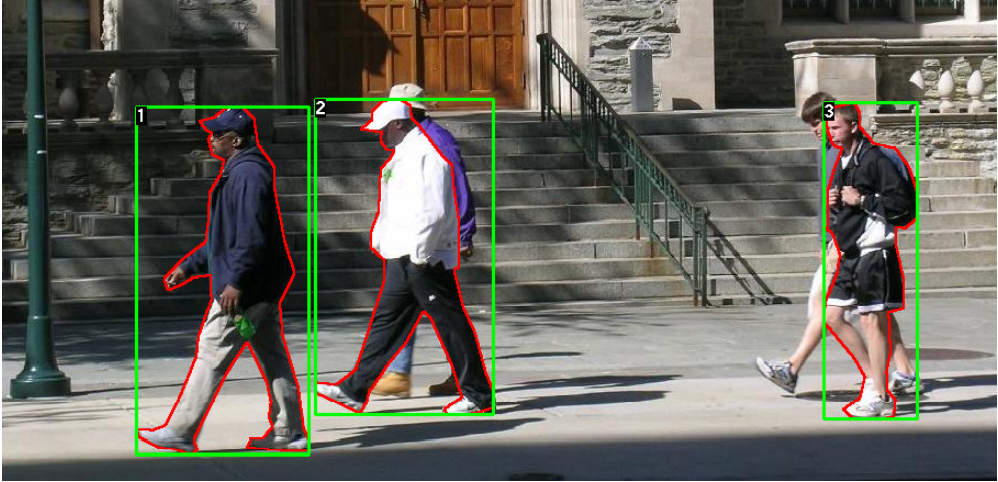
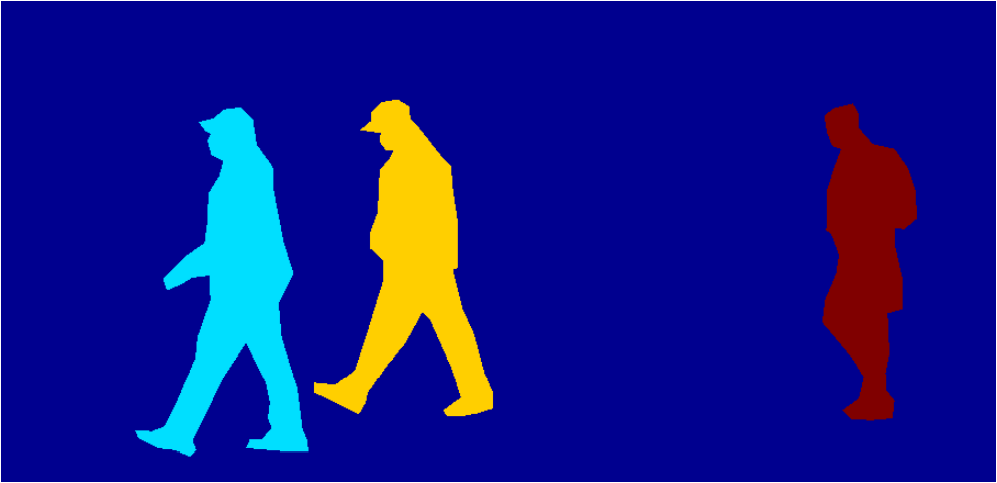

因此每个图像具有相应的分割掩膜，其中每个颜色对应于不同的实例。让我们为这个数据集写一个 `torch.utils.data.Dataset` 类。

#### 2.2 为数据集编写类

In [1]:
import os
import numpy as np
import torch
from PIL import Image

In [12]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # 下载所有图像文件，为其排序
        # 确保它们对齐
        self.imgs = list(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = list(os.listdir(os.path.join(root, "PedMasks")))
    
    def __getitem__(self, idx):
        # load images ad masks
        
    
    def __len__(self):
        return len(self.imgs)

In [13]:
root='../../data/PennFudanPed'
pfd = PennFudanDataset(root=root, transforms=None)
for img, mask in zip(pfd.imgs[:5], pfd.masks[:5]):
    print(img, mask)
print(len(pfd))

FudanPed00001.png FudanPed00001_mask.png
FudanPed00002.png FudanPed00002_mask.png
FudanPed00003.png FudanPed00003_mask.png
FudanPed00004.png FudanPed00004_mask.png
FudanPed00005.png FudanPed00005_mask.png
170
